In [26]:
import matplotlib.pyplot as plt
import mnist
import numpy as np

In [27]:
#initializaation
train_data, train_labels, test_data, test_labels = mnist.load_data()
m0 = 784
m1 = 100
m2 = 100
m3 = 10

In [28]:
#Normalizing
train_mean = train_data.mean()
test_mean = test_data.mean()
train_std = test_data.std()
test_std = test_data.std()

train_data = (train_data - train_mean) / train_std
test_data = (test_data - test_mean) / test_std


In [29]:
#get OneHot Vectors
def one_hot(label):
    b = np.zeros((label.size, label.max() + 1))
    b[np.arange(label.size), label] = 1
    return b


In [30]:
train_labels_one_hot = one_hot(train_labels)
test_labels_one_hot = one_hot(test_labels)

#initialise Weights Xavier Normal
# print(train_labels[1], train_labels_one_hot[1])
W1 = np.random.normal(0, 1 / np.sqrt(m0), (m1, m0 + 1))
W2 = np.random.normal(0, 1 / np.sqrt(m1), (m2, m1 + 1))
W3 = np.random.normal(0, 1 / np.sqrt(m2), (m3, m2 + 1))

V1 = np.zeros(W1.shape)
V2 = np.zeros(W2.shape)
V3 = np.zeros(W3.shape)

In [31]:
tan_h = lambda x_: np.tanh(x_)
output_ac_fn = lambda x_: np.maximum(x_, 0).astype(int)
d_tan_h = lambda x_: 1 - (np.tanh(x_) ** 2)
sigmoid = lambda x_: 1 / (1 + np.exp(-x_))
d_sigmoid = lambda x_: sigmoid(x_) * (1 - sigmoid(x_))
d_output_ac_fn = lambda x_: 1

In [32]:
#Hyper Parms
learning_rate = 0.01
momentum = 0.15
train_errors = []
energy_train = []
test_errors = []
energy_test = []
MSE = []
MSE_test = []
epoch = 0

n = 60000
n_test = 10000

In [41]:
#Algo
print("MSE Train\t\tMSE Test\t\tEta\tEpoch\tAccuracy_train\tAccuracy_test")
unit_vector = np.array([1]).reshape(1, 1)
while (True):
    # print(W1, W2)
    y_3s = []
    y_3s_test = []
    correct = 0
    E_train = 0
    for i in range(n):

        y0 = np.array(train_data[i]).reshape(784, 1)
        int_y0 = np.vstack((unit_vector, y0))
        v_1 = W1 @ int_y0
        y_1 = sigmoid(v_1)

        int_y1 = np.vstack((unit_vector, y_1))
        v_2 = W2 @ int_y1
        y_2 = sigmoid(v_2)

        int_y2 = np.vstack((unit_vector, y_2))
        v_3 = W3 @ int_y2
        y_3 = sigmoid(v_3)
        y_3s.append(y_3)

        check = (np.argmax(y_3) == train_labels[i])
        if check == True:
            correct += 1

        E_train += np.sum((train_labels_one_hot[i].reshape(y_3.shape) - y_3) ** 2) / (2 * n)

        d_3 = np.multiply((train_labels_one_hot[i].reshape(y_3.shape) - y_3), d_sigmoid(v_3))
        d_2 = np.multiply((np.transpose(W3) @ d_3)[1:, :], d_sigmoid(v_2))
        d_1 = np.multiply((np.transpose(W2) @ d_2)[1:, :], d_sigmoid(v_1))

        de_dW1 = -d_1 @ int_y0.transpose()
        de_dW2 = -d_2 @ int_y1.transpose()
        de_dW3 = -d_3 @ int_y2.transpose()

        V1 = np.subtract(np.multiply(momentum, V1), np.multiply(learning_rate, de_dW1))
        V2 = np.subtract(np.multiply(momentum, V2), np.multiply(learning_rate, de_dW2))
        V3 = np.subtract(np.multiply(momentum, V3), np.multiply(learning_rate, de_dW3))

        W1 = W1 + V1
        W2 = W2 + V2
        W3 = W3 + V3
        # print(train_labels[i], y_3s[i])
    energy_train.append(E_train)
    train_errors.append(n - correct)
    
    
    E_test = 0
    correct_test = 0
    for i in range(n_test):
        y0 = np.array(test_data[i]).reshape(784, 1)
        int_y0 = np.vstack((unit_vector, y0))
        v_1 = W1 @ int_y0
        y_1 = sigmoid(v_1)

        int_y1 = np.vstack((unit_vector, y_1))
        v_2 = W2 @ int_y1
        y_2 = sigmoid(v_2)

        int_y2 = np.vstack((unit_vector, y_2))
        v_3 = W3 @ int_y2
        y_3 = sigmoid(v_3)
        y_3s_test.append(y_3)

        check = (np.argmax(y_3) == test_labels[i])
        if check == True:
            correct_test += 1
        E_test += np.sum((test_labels_one_hot[i].reshape(y_3.shape) - y_3) ** 2) / (2 * n)
    energy_test.append(E_test)
    test_errors.append(n_test - correct_test)

    sum_ = 0
    for i in range(n):
        sum_ += np.square(np.subtract(train_labels_one_hot[i].reshape(y_3.shape),y_3s[i])).mean()
    mse = (sum_ / (n))
    MSE.append(mse)

    sum_ = 0
    for i in range(n_test):
        sum_ += np.square(np.subtract(test_labels_one_hot[i].reshape(y_3.shape),y_3s_test[i])).mean()
    mse_test = (sum_ / (n_test))
    MSE_test.append(mse_test)

    if epoch != 0:
        if MSE[epoch] > MSE[epoch - 1]:
            learning_rate = learning_rate * 0.9
        if (correct_test / n_test) >= 0.99 or (correct/n) >0.996:
            break

    epoch += 1
print(MSE[-1], MSE_test[-1], learning_rate, epoch, correct / n, correct_test / n_test)

MSE Train		MSE Test		Eta	Epoch	Accuracy_train	Accuracy_test
0.00038213824978997025 0.004142959230839573 0.01 131 0.99685 0.9771


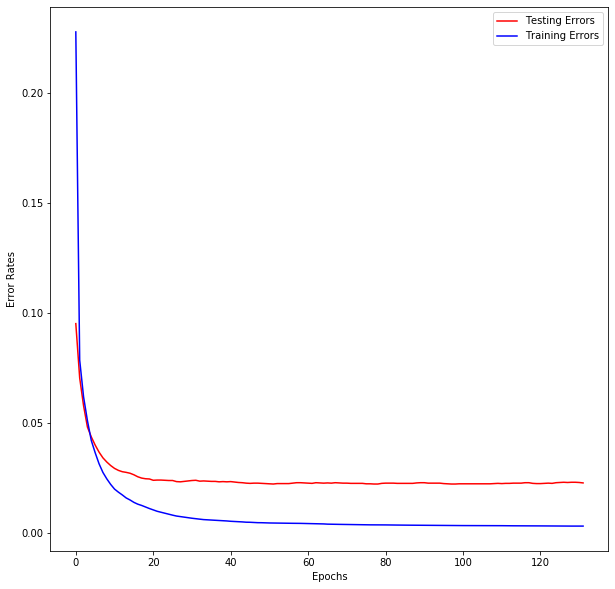

In [39]:
fig, ax = plt.subplots(figsize=(10,10))
plt.xlabel('Epochs')
plt.ylabel('Error Rates')
plt.plot(range(len(test_errors)), np.array(test_errors)/n_test, c ='red', label='Testing Errors')
plt.plot(range(len(train_errors)), np.array(train_errors)/n, c='blue', label='Training Errors')
plt.legend(loc = 'best')
plt.show()


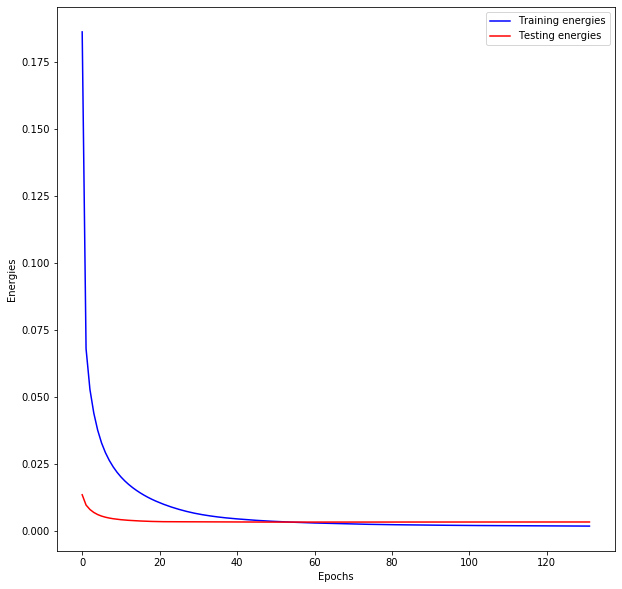

In [40]:
fig, ax = plt.subplots(figsize=(10,10))
plt.xlabel('Epochs')
plt.ylabel('Energies')
plt.plot(range(len(energy_train)), energy_train, c='blue', label='Training energies')
plt.plot(range(len(energy_test)), energy_test, c='red', label='Testing energies')
plt.legend(loc = 'best')
plt.show()


